In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd 
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# dynamic time warping
from dtw import *
from scipy.cluster.hierarchy import dendrogram, linkage
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [8]:
#read_data
ts_data = pd.read_csv('data/ndap_series.csv')
ts_data.shape

(2016, 558)

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level



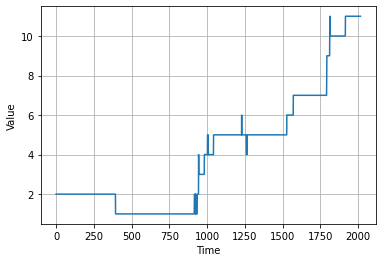

In [35]:
idx = 200
series = ts_data[ts_data.columns[idx]]
time = np.arange(len(series), dtype="float32")

plot_series(time, series)

In [27]:
split_time = ts_data.shape[0]-400
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [28]:
len(x_train)

1616

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [30]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[ 0.279206  ],
       [ 0.57920945],
       [-0.39680997],
       [ 0.3781594 ],
       [ 0.12029012],
       [-0.11921167],
       [ 0.20446685],
       [ 0.37050426],
       [-0.18329825],
       [ 0.28177974],
       [-0.35960186],
       [-0.45035896],
       [ 0.06778548],
       [ 0.12355756],
       [-0.36190942],
       [-0.32422546],
       [ 0.18905656],
       [ 0.30272013],
       [ 0.37694907],
       [-0.06290614]], dtype=float32), array([0.01870367], dtype=float32)]


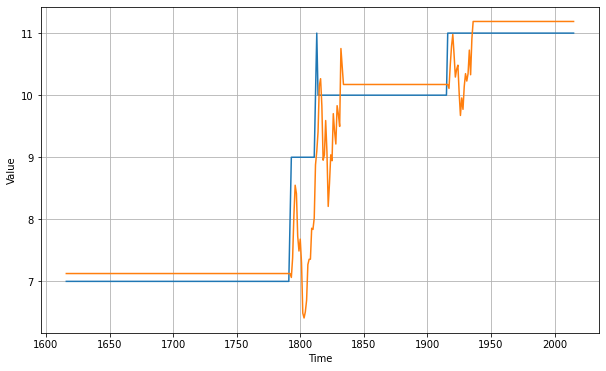

In [43]:
forecast = []

for t in range(len(series) - window_size):
    forecast.append(model.predict(np.array(series)[t:t + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
model.save('model/ts200_model')
#new_model = tf.keras.models.load_model('model/ts200_model')
# Check its architecture
#new_model.summary()

INFO:tensorflow:Assets written to: model/ts200_model/assets


2021-12-27 14:24:01.420071: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
